In [117]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import math
import itertools
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# mimic r behavior
from siuba import _, group_by, mutate, select
import plotnine
import janitor

In [180]:
df.shape

(1048575, 18)

In [118]:
pd.options.display.max_columns = 500 # this will set limit of columns to 500

os.getcwd()

# Load dataset
df = pd.read_csv("optiver-trading-at-the-close/train.csv")

In [119]:
def to_datetime(year, week, dow, minute, seconds):
    dt = str(datetime.fromisocalendar(year, week, dow+1))
    dt = dt[:10]
    dt = dt + str(' 00:0') + str(minute) + ':' + str(seconds)
    return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')

In [120]:
# MAKE SURE WE ACTUALLY HAVE DATE DATA!!!

 # Make date index
df["dow"] = df["date_id"] % 5
df["seconds"] = df["seconds_in_bucket"] % 60  
df["minute"] = df["seconds_in_bucket"] // 60 
df['week_number'] = [int((a/5) + 1) for a in df['date_id']]

df['time'] = df.apply(lambda x: to_datetime(2022, x['week_number'], x['dow'], x['minute'],x['seconds']), axis = 1)
df.index = df['time']
df = df.drop(['row_id', 'date_id', 'time_id', 'time'], axis = 1)

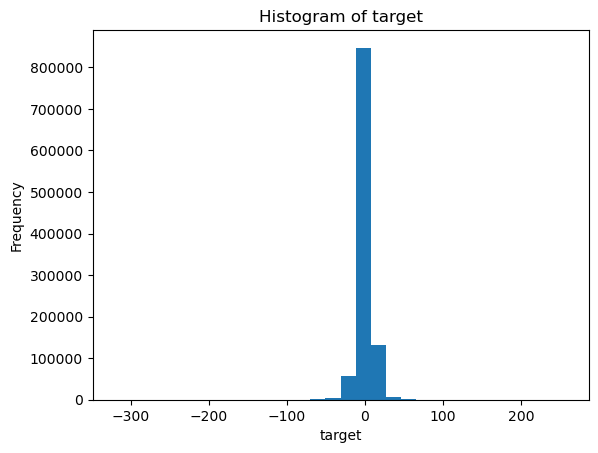

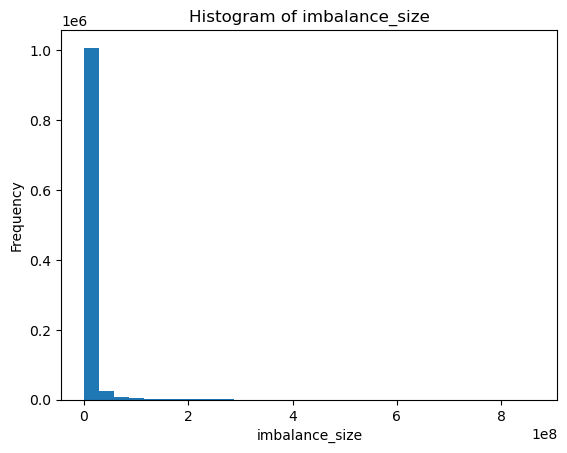

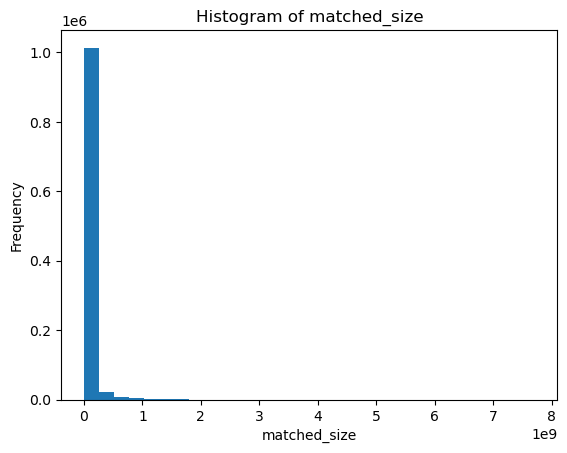

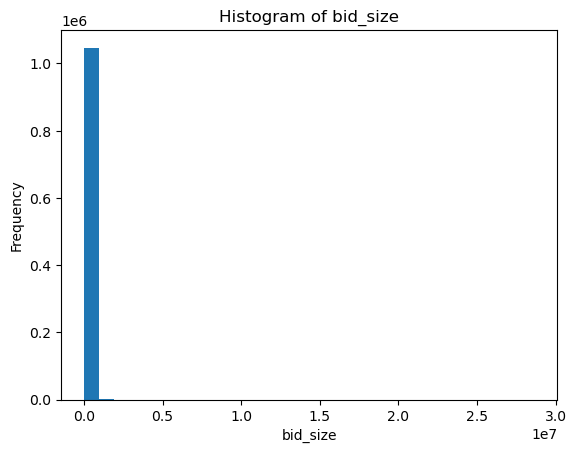

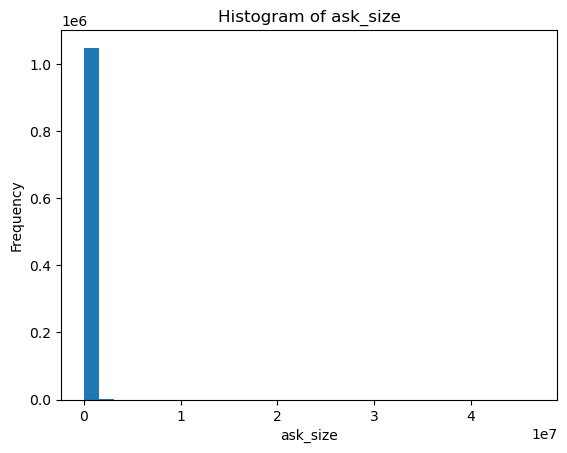

In [89]:
feature = 'target'

plt.hist(df[feature], bins=30)

plt.title('Histogram of ' + feature)
plt.xlabel(feature)
plt.ylabel('Frequency')

plt.show()

##########################################

feature = 'imbalance_size'

plt.hist(df[feature], bins=30)

plt.title('Histogram of ' + feature)
plt.xlabel(feature)
plt.ylabel('Frequency')

plt.show()

##########################################

feature = 'matched_size'

plt.hist(df[feature], bins=30)

plt.title('Histogram of ' + feature)
plt.xlabel(feature)
plt.ylabel('Frequency')

plt.show()

##########################################

feature = 'bid_size'

plt.hist(df[feature], bins=30)

plt.title('Histogram of ' + feature)
plt.xlabel(feature)
plt.ylabel('Frequency')

plt.show()

##########################################

feature = 'ask_size'

plt.hist(df[feature], bins=30)

plt.title('Histogram of ' + feature)
plt.xlabel(feature)
plt.ylabel('Frequency')

plt.show()

In [121]:
df_train = df[df.index <= to_datetime(2022, 18, 0, 0, 0)]
df_test = df[df.index > to_datetime(2022, 18, 0, 0, 0)]

In [168]:
def df_to_X_y(df, window_size):
    X = []
    y = []
    for i in range(df.shape[0]-window_size):
        X.append(df[i:i+window_size])
        y.append(df.iloc[i+window_size,]['target'])
    X = np.array(X).astype(np.float)
    y = np.array(y).astype(np.float)
    return X,y

def fixNa(df):
        def na_to_int(x):
             if pd.isna(x):
                  return -999999999999
             return x
        for i in df.columns:
            df[i] = [na_to_int(x) for x in df[i]]
        return df

def reverseFixNa(df):
        def int_to_na(x):
             if x==-999999999999:
                  return None
             return x
        for i in df.columns:
            df[i] = [int_to_na(x) for x in df[i]]
        return df

def ln_data_transform(x, mean):
        if x == 0:
            if mean < 0:
                return -1* math.log(-1*mean)
            return math.log(mean)
        elif (x<0):
            return -1 * math.log(-1*x)      
        return math.log(x)

def reverse_ln_data_transform(x):
    if (x < 0):
        return -1 * np.exp(-x)     
    return np.exp(x)

def preprocess(df):
    df=pd.DataFrame(df)
    
    columns = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size', 'target']
    for i in columns:
        mean = df[i].mean()
        df[i] = [ln_data_transform(x, mean) for x in df[i]]

    df = fixNa(df)
    return df

def stockLSTM(df, stock_num):
    df=pd.DataFrame(df)
    df = df[pd.notna(df['target'])]
    df = df[df['stock_id'].isin([stock_num])]
    
    df = preprocess(df)
    
    X,y = df_to_X_y(df, 15)

    breakoff = int(df.shape[0]*0.9)
    X_train, y_train, X_val, y_val = X[:breakoff], y[:breakoff], X[breakoff:], y[breakoff:]

    model = Sequential()
    model.add(LSTM(units=16,return_sequences=True,input_shape=(15, 18)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam',loss='mae')
    model.fit(X, y, validation_data=(X_val, y_val), epochs=120,batch_size=32)
    
    return model

In [ ]:
# thisX, thisy = df_to_X_y(preprocess(df_train[df_train['stock_id']==0]), 15)
# print(mean_absolute_error(model0.predict(thisX), thisy))
# print(mean_absolute_error(len(thisy)*[thisy.mean()], thisy))

In [ ]:
to_train = preprocess(df_train)

to_predict = df_test
to_predict = preprocess(to_predict)
to_predict_nullprocessingproxy = pd.DataFrame(to_predict)
to_predict_nullprocessingproxy['target']=None

# get first day, add 150 seconds, # year, week, dow, minute, seconds)
print(to_predict_nullprocessingproxy.index[0])
testfor15entries = to_predict_nullprocessingproxy[to_predict_nullprocessingproxy.index <= to_datetime(2022, 18, 0, 2, 30)]
testfor15entries = testfor15entries[testfor15entries['stock_id']==0]
print("15 entries?: ", testfor15entries.shape[0]==15)

# we cannot get predictions for first 15 days. we'll output null.
to_predict_nullprocessingproxy = to_predict_nullprocessingproxy[to_predict_nullprocessingproxy.index > to_datetime(2022, 18, 0, 2, 30)]

modelDict = {}
for i in range(len(df_test['stock_id'].unique())-196):
    thisStock = df_test['stock_id'].unique()[i]
    thisModel = stockLSTM(to_train, thisStock)
    thisX, thisy = df_to_X_y(to_predict[to_predict['stock_id']==thisStock], 15)
    to_predict_nullprocessingproxy['target'][to_predict_nullprocessingproxy['stock_id']==thisStock] = thisModel.predict(thisX).flatten()
    modelDict[str(i)]=thisModel

to_predict_nullprocessingproxy



In [94]:
to_predict['target'][to_predict.index <= to_datetime(2022, 18, 0, 2, 30)] = None

/var/folders/ht/0m8f7gjx26s_9z8dxrbq7l1c0000gn/T/ipykernel_7503/228875710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
final = pd.merge(
    left=to_predict,
    right=to_predict_nullprocessingproxy['target'],
    left_on=[to_predict['stock_id'], to_predict.index],
    right_on=[to_predict_nullprocessingproxy['stock_id'], to_predict_nullprocessingproxy['target'].index],
    how="left"
)

# final = final[df.columns[df.columns != 'target']] + final['target_x'] + final['target_y']

In [96]:
getFinalColumns = list(df.columns[df.columns != 'target'])
getFinalColumns.append('target_x')
getFinalColumns.append('target_y')

final = final[getFinalColumns]

In [ ]:
final[final['stock_id']==0]

In [129]:
preprocess(df_train[df_train['stock_id']==0]).describe()

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,dow,seconds,minute,week_number
count,4676.0,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4.676000e+03,4.676000e+03,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000
mean,0.0,269.942258,14.426376,-0.104577,0.999843,16.581959,-5.494012e+11,-5.455518e+11,0.999747,9.826697,0.999937,9.928956,0.999840,-0.050331,1.999572,24.540205,4.090034,9.001925
std,0.0,158.794176,1.216851,0.846239,0.001138,0.510557,4.976067e+11,4.979740e+11,0.001143,1.336001,0.001132,1.260659,0.001137,1.385156,1.414516,17.252522,2.644866,4.900747
min,0.0,0.000000,4.518849,-1.000000,0.995006,15.313852,-1.000000e+12,-1.000000e+12,0.992981,4.427956,0.995252,4.401094,0.994443,-4.652603,0.000000,0.000000,0.000000,1.000000
25%,0.0,130.000000,14.059680,-1.000000,0.999190,16.229904,-1.000000e+12,-1.000000e+12,0.999101,9.188683,0.999278,9.330314,0.999188,-1.160034,1.000000,10.000000,2.000000,5.000000
50%,0.0,270.000000,14.679637,0.000000,0.999820,16.551325,-1.000000e+12,-1.000000e+12,0.999728,10.040516,0.999919,10.138967,0.999826,-0.049013,2.000000,20.000000,4.000000,9.000000
75%,0.0,410.000000,15.060871,1.000000,1.000513,16.902912,9.988630e-01,9.989900e-01,1.000404,10.666464,1.000604,10.713220,1.000508,1.098778,3.000000,40.000000,6.000000,13.000000
max,0.0,540.000000,17.287227,1.000000,1.003711,18.498503,1.102424e+00,1.051456e+00,1.003711,13.407582,1.003936,13.822147,1.003750,4.591979,4.000000,50.000000,9.000000,18.000000


In [ ]:
data = df_train[df_train['stock_id']==0]
model0 = stockLSTM(data, 0)
thisX, thisY = df_to_X_y(preprocess(data), 15)
# predictions = model0.predict(thisX)
# actuals = thisY

# print(mean_absolute_error(model0.predict(thisX), thisy))
# print(mean_absolute_error(len(thisy)*[thisy.mean()], thisy))

In [ ]:
predictions = model0.predict(thisX).flatten()
actuals = thisY

# print(predictions)
print(thisY)

resultsFrame = pd.DataFrame(predictions, thisY).reset_index()
resultsFrame.columns = ['actuals', 'predictions']
resultsFrame



print(mean_absolute_error(len(thisy)*[thisy.mean()], thisy))
print(mean_absolute_error(resultsFrame['actuals'], resultsFrame['predictions']))


In [169]:
resultsFrameNaturalRaised = resultsFrame

# Assuming resultsframe is your dataframe
resultsFrameNaturalRaised = resultsFrameNaturalRaised.applymap(reverse_ln_data_transform)

In [ ]:
resultsFrameNaturalRaised

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'resultsframe' is your DataFrame and it has columns 'actual' and 'predictions'
plt.figure(figsize=(10, 6))

# Plot 'actual' column
plt.plot(resultsFrameNaturalRaised.index, resultsFrameNaturalRaised['actuals'], label='Actual')

# Plot 'predictions' column
plt.plot(resultsFrameNaturalRaised.index, resultsFrameNaturalRaised['predictions'], label='Predictions')

plt.title('Actual vs Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.show()


In [179]:
print(mean_absolute_error(len(resultsFrameNaturalRaised['actuals'])*[resultsFrameNaturalRaised['actuals'].mean()], resultsFrameNaturalRaised['actuals']))
print(mean_absolute_error(resultsFrameNaturalRaised['actuals'], resultsFrameNaturalRaised['predictions']))

7.4524615621005275
5.463277412173005
